[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Komatsu-T/Samples/blob/main/machine_learning/LightGBM/LightGBM_regression_optuna_tuning_1.ipynb)

# LightGBM Regression sample by optuna LightGBM Tuner
### Crossvalidation emsemble model

### Import libraries

In [52]:
!pip install shap optuna optuna-integration

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import loguniform
from tqdm import tqdm

import optuna.integration.lightgbm as lgb
import shap

### Dataset

In [54]:
# ----------------------------------------------
# Create sample dataset
# ----------------------------------------------

# Dataset
housing = fetch_california_housing()
housing_data = pd.DataFrame(data = housing.data, columns = housing.feature_names)
housing_data['target'] = housing.target
housing_data.reset_index(inplace = True, drop = True)

# Functions
def make_correlation_category(x_grid, y_grid, x_feature_name, y_feature_name, datset, catefory_names = list('ABCDEFGHIJKLMNOPQLSTUVWXYZ')):
    i = 0
    index_list = []
    category_list = []
    for y1, y2 in zip(y_grid[:-1], y_grid[1:]):
        for x1, x2 in zip(x_grid[:-1], x_grid[1:]):
            temp_data = datset[(x1<=datset[x_feature_name]) & (datset[x_feature_name]<x2) & (y1<=datset[y_feature_name]) & (datset[y_feature_name]<y2)].copy()
            if temp_data.shape[0] > 0:
                index_list += temp_data.index.tolist()
                category_list += [catefory_names[i] for k in range(temp_data.shape[0])]
                i += 1
    return np.array(category_list)[np.argsort(np.array(index_list))]

# Make categorical features 1
housing_data['Area_category'] = make_correlation_category(
    x_grid = [32, 34, 36, 38, 40, 44],
    y_grid = [-126, -122, -120, -118, -116, -114],
    x_feature_name = 'Latitude',
    y_feature_name = 'Longitude',
    datset = housing_data,
)

# Make categorical features 2
housing_data['Room_num_category'] = make_correlation_category(
    x_grid = [0, 5, 10, 40],
    y_grid = [0, 20, 40, 170],
    x_feature_name = 'AveBedrms',
    y_feature_name = 'AveRooms',
    datset = housing_data,
)

In [55]:
# ----------------------------------------------
# Categorical encoding
# ----------------------------------------------

categorical_featues = ['Area_category', 'Room_num_category']
categorical_encoders = {}
for col in categorical_featues:
    enc = LabelEncoder()
    enc.fit(housing_data[col].unique())
    housing_data[col+'_encoded'] = enc.transform(housing_data[col])
    categorical_encoders[col] = enc

In [56]:
housing_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,Area_category,Room_num_category,Area_category_encoded,Room_num_category_encoded
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,A,A,0,0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,A,A,0,0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,A,A,0,0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,A,A,0,0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,A,A,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,F,A,5,0
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,F,A,5,0
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,F,A,5,0
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,F,A,5,0


### Training LGBM Regression

In [57]:
# ----------------------------------------------
# Parameters
# ----------------------------------------------

fixed_parameters = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1
}

In [58]:
%%time
# ----------------------------------------------
# Training (Duble cross validation)
# ----------------------------------------------

# Settings
num_time = 3600 # total seconds
early_stopping_rounds = 50

# Feature names
num_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
cat_features = ['Area_category_encoded', 'Room_num_category_encoded']
target = ['target']

# Feature, target dataset
X = housing_data[num_features+cat_features].copy()
y = housing_data[target].copy()

# Outer cross validation
models = {}
plot_data = {}
parameter_tuning_data = pd.DataFrame()
outer_kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
num_time = num_time/outer_kfold.n_splits
for outer_fold, (train_valid_index, test_index) in enumerate(outer_kfold.split(X)):
    print('====================================================================================')
    print(f' Outer fold: {outer_fold}')
    print('====================================================================================')

    # Test split
    X_train_valid, X_test = X.iloc[train_valid_index], X.iloc[test_index]
    y_train_valid, y_test = y.iloc[train_valid_index], y.iloc[test_index]

    # Valid split
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle = True, test_size = 0.2, random_state = 123)

    # LGBM datset
    lgb_data_train = lgb.Dataset(X_train, label = y_train)
    lgb_data_valid = lgb.Dataset(X_valid, label = y_valid)

    # Fitting
    best_params, tuning_history = dict(), list()
    model = lgb.train(
        fixed_parameters,
        lgb_data_train,
        valid_sets = lgb_data_valid,
        num_boost_round = 10000,
        callbacks = [lgb.early_stopping(stopping_rounds = early_stopping_rounds, verbose = False), lgb.log_evaluation(-1)],
        time_budget = num_time,
    )

    # Evaluation
    pred_y_train = model.predict(X_train_valid)
    pred_y_test = model.predict(X_test)
    train_RMSE = mean_squared_error(y_true = y_train_valid.values.ravel(), y_pred = pred_y_train, squared = False)
    test_RMSE = mean_squared_error(y_true = y_test.values.ravel(), y_pred = pred_y_test, squared = False)
    plot_data[outer_fold] = {"pred_y_train": pred_y_train, 'true_y_train': y_train_valid.values.ravel(),
                             "pred_y_test": pred_y_test, 'true_y_test': y_test.values.ravel(),
                             'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE}

    # Model save
    models[outer_fold] = {'Model': model, 'RMSE': test_RMSE}

[I 2024-09-14 14:48:43,241] A new study created in memory with name: no-name-b3f72169-8e58-4816-a0c6-414966bfe32f


 Outer fold: 0


min_child_samples, val_score: 0.437839: 100%|##########| 5/5 [00:04<00:00,  1.18it/s]
[I 2024-09-14 14:50:11,724] A new study created in memory with name: no-name-34d72e30-15a8-45a3-b02f-cc5b1454e267


 Outer fold: 1


min_child_samples, val_score: 0.439126: 100%|##########| 5/5 [00:08<00:00,  1.60s/it]
[I 2024-09-14 14:51:43,502] A new study created in memory with name: no-name-6176a156-b787-4e56-b4da-b397394b0027


 Outer fold: 2


min_child_samples, val_score: 0.422079: 100%|##########| 5/5 [00:11<00:00,  2.22s/it]
[I 2024-09-14 14:53:29,350] A new study created in memory with name: no-name-5847fcef-6d4b-4466-9118-f39e7774eaeb


 Outer fold: 3


min_child_samples, val_score: 0.466706: 100%|##########| 5/5 [00:04<00:00,  1.03it/s]
[I 2024-09-14 14:54:55,063] A new study created in memory with name: no-name-ecb8f70e-0ae6-494f-9d76-5b57e93e9ca4


 Outer fold: 4


min_child_samples, val_score: 0.440777: 100%|##########| 5/5 [00:05<00:00,  1.18s/it]


CPU times: user 12min 16s, sys: 15.5 s, total: 12min 31s
Wall time: 7min 32s


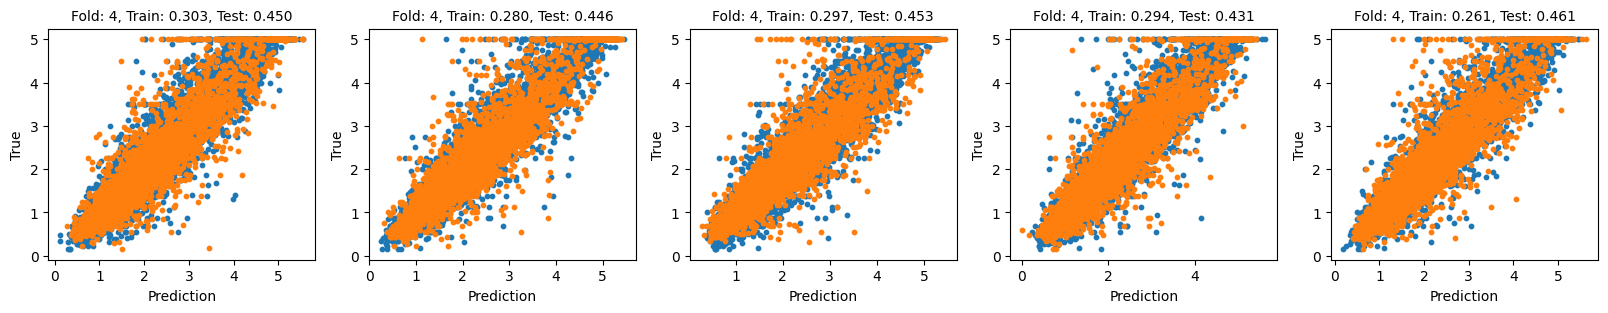

In [59]:
# ----------------------------------------------
# Plot
# ----------------------------------------------

fig, ax = plt.subplots(1, 5, figsize = (20, 3))
for fold, plot_info in plot_data.items():
    ax[fold].scatter(plot_info['pred_y_train'], plot_info['true_y_train'], s = 10, label = 'Train')
    ax[fold].scatter(plot_info['pred_y_test'], plot_info['true_y_test'], s = 10, label = 'Test')
    train_RMSE = plot_info['train_RMSE']
    test_RMSE = plot_info['test_RMSE']
    ax[fold].set_title(f'Fold: {outer_fold}, Train: {train_RMSE:.3f}, Test: {test_RMSE:.3f}', fontsize = 10)
    ax[fold].set_xlabel('Prediction')
    ax[fold].set_ylabel('True')
plt.show()

### Inference

In [60]:
# ----------------------------------------------
# Trained model class
# ----------------------------------------------

class TrainedLGBMRegressor():
    def __init__(self, models, categorical_encoders, num_feature_names, cat_feature_names):
        self.models = models
        self.categorical_encoders = categorical_encoders
        self.num_feature_names = num_feature_names
        self.cat_feature_names = cat_feature_names
        self.weight = [1/j['RMSE'] for i, j in models.items()]/np.sum([1/j['RMSE'] for i, j in models.items()])

    def predict(self, dataset):
        # Categorical encode
        for col, enc in self.categorical_encoders.items():
            dataset[col+"_encoded"] = enc.transform(dataset[col])

        # Prediction
        pred_values = np.zeros(dataset.shape[0])
        for model_info, weight in zip(self.models.values(), self.weight):
            pred_values += model_info['Model'].predict(dataset[self.num_feature_names+self.cat_feature_names])*weight
        return pred_values

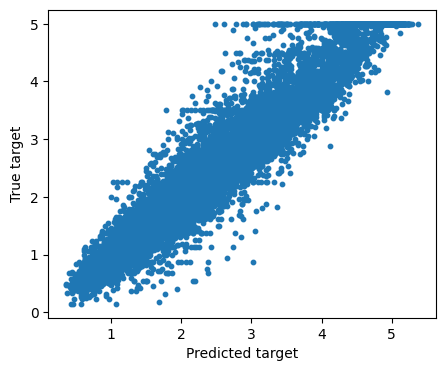

In [61]:
# ----------------------------------------------
# Inference
# ----------------------------------------------

# New Dataset (like)
new_dataset = housing_data.drop(columns = ['Area_category_encoded', 'Room_num_category_encoded']).copy()

# Trained model instance
trained_model = TrainedLGBMRegressor(
    models,
    categorical_encoders,
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    ['Area_category_encoded', 'Room_num_category_encoded']
)

# Prediction
new_dataset['Predicted_value'] = trained_model.predict(new_dataset)

# Plot
fig, ax = plt.subplots(1, 1, figsize = (5, 4))
ax.scatter(new_dataset['Predicted_value'], new_dataset['target'], s = 10)
ax.set_xlabel('Predicted target')
ax.set_ylabel("True target")
plt.show()